In [358]:
import numpy as np
import sys, json, copy, time, pickle, random
from concurrent.futures import ThreadPoolExecutor
import qiskit
from qiskit import IBMQ, QuantumCircuit, execute
# from qiskit.providers.aer import StatevectorSimulator, AerSimulator
from qiskit.providers.aer.noise import NoiseModel, pauli_error, amplitude_damping_error, ReadoutError
import qiskit.ignis.verification.randomized_benchmarking as rb
# from qiskit.providers.aer.noise.errors.errorutils import single_qubit_clifford_gates
# from qiskit.providers.ibmq.managed import IBMQJobManager, ManagedJobSet
# sfrom qiskit.providers.ibmq.apiconstants import ApiJobShareLevel
from qiskit.qobj.utils import MeasLevel
from sympy import N
from qubit_map import qubit_maps
import matplotlib.pyplot as plt
from scipy.stats import sem, unitary_group
# from scipy import sparse
import CB_process
from statistics import stdev
import itertools
# from qiskit.compiler import transpile
from scipy.stats.mstats import gmean
#Change test

use_density_matrix = False # density matrix based / measurement based simulation

#filename_label = 'simulation_all_20220510_7020807191' #S3e-2
#filename_label = 'simulation_all_20220510_8102820093' #S3e-3
#filename_label = 'simulation_all_20220510_7608340463' #S3e-4
#-
#filename_label = 'simulation_all_20220510_1843161046' #M3e-2
#filename_label = 'simulation_all_20220510_9394336719' #M3e-4
filename_label = 'simulation_all_20220510_4063263060' #M3e-3
#filename_label = 'simulation_all_20220510_0875351121' #M1e-4
#---
#filename_label = 'simulation_all_20220207_9877657681' #M1e-1
#filename_label = 'simulation_all_20220207_5370500716' #S1e-4
#filename_label = 'simulation_all_20220207_0138295296' #S1e-2
#filename_label = 'simulation_all_20220207_1554639290' #S1e-3
#filename_label = 'simulation_intc_20220207_0182433690'
#filename_label = 'simulation_all_20220207_8562200401'  #M1e-2
#filename_label = 'simulation_all_20220207_7011425106'  #M1e-3
#filename_label = 'simulation_all_20220207_7738569296'
#filename_label = 'simulation_all_20220207_7420679527'
#filename_label = 'ibmq_experiment_all_20220131_3975437641'




with open('data/' + filename_label + '_result', 'rb') as infile:
    result = pickle.load(infile)

C = result['cb']['C']
shots = result['cb']['shots']
C_intc = result['intc_cb']['C']
shots_intc = result['intc_cb']['shots']
Lrange = result['cb']['Lrange']


In [359]:
#Todo: calculate the true f_true...

# f_true_in = {
#     "II": 0.00, 
#     "IX": 0.0025, 
#     "IY": 0.0025, 
#     "IZ": 0.005, 
#     "XI": 0.0025, 
#     "XX": 0.005,
#     "XY": 0.005, 
#     "XZ": 0.0075, 
#     "YI": 0.0025, 
#     "YX": 0.005, 
#     "YY": 0.005, 
#     "YZ": 0.0075, 
#     "ZI": 0.005, 
#     "ZX": 0.0075, 
#     "ZY": 0.0075, 
#     "ZZ": 0.01
# }

# f_true = {}
# for key,value in f_true_in.items():
#     f_true[key] = 1-value

f_true ={'II': 0.9999999999999998,
 'IX': 0.9974968671630001,
 'IY': 0.9974968671630001,
 'IZ': 0.9949999999999999,
 'XI': 0.9974968671630001,
 'XX': 0.9949999999999999,
 'XY': 0.9949999999999999,
 'XZ': 0.992509382827185,
 'YI': 0.9974968671630001,
 'YX': 0.9949999999999999,
 'YY': 0.9949999999999999,
 'YZ': 0.992509382827185,
 'ZI': 0.9949999999999999,
 'ZX': 0.992509382827185,
 'ZY': 0.992509382827185,
 'ZZ': 0.9900249999999999}

In [360]:
cb_fidelity_list = result['cb']['fidelity']
cb_stdev_list = result['cb']['stdev']

deg_list1 = ['II','XI','IZ','XZ','{ZI,ZZ}','{IX,XX}','{YI,YZ}','{IY,XY}','{ZX,YY}','{YX,ZY}']
cb_deg_fidelity = {} 
cb_deg_stdev = {}
cb_true = {}
for label in deg_list1:
    if len(label) == 2:
        cb_deg_fidelity[label] = cb_fidelity_list[label]
        cb_deg_stdev[label] = cb_stdev_list[label]
        cb_true[label] = f_true[label]
    else:
        pp1 = label[1:3]
        pp2 = label[4:6]
        cb_deg_fidelity[label] = (cb_fidelity_list[pp1]+cb_fidelity_list[pp2])/2
        cb_deg_stdev[label] = np.sqrt(cb_stdev_list[pp1]**2 + cb_stdev_list[pp2]**2)
        cb_true[label] = (f_true[pp1] + f_true[pp2])/2

snr_std = 0
for label,f in cb_deg_fidelity.items():
    if len(label)==len('II'):
        snr_std += f
    else:
        snr_std +=2*f
snr_std /= 16

snr_std_stdev = 0
for label,std in cb_deg_stdev.items():
    if len(label)==len('II'):
        snr_std_stdev += std**2
    else:
        snr_std_stdev +=4*std**2
snr_std_stdev = np.sqrt(snr_std_stdev)/16

########### int_CB estimate
icb_fidelity_list = result['int_cb']['fidelity']
icb_stdev_list = result['int_cb']['stdev']

deg_list2 = ['II','XI','IZ','XZ','ZX','YX','ZY','YY','{ZI,YZ}','{IX,XY}','{YI,ZZ}','{IY,XX}']
icb_deg_fidelity = {} 
icb_deg_stdev = {}
icb_true = {}
for label in deg_list2:
    if len(label) == 2:
        icb_deg_fidelity[label] = icb_fidelity_list[label]
        icb_deg_stdev[label] = icb_stdev_list[label]
        icb_true[label] = f_true[label]
    else:
        pp1 = label[1:3]
        pp2 = label[4:6]
        icb_deg_fidelity[label] = (icb_fidelity_list[pp1]+icb_fidelity_list[pp2])/2
        icb_deg_stdev[label] = np.sqrt(icb_stdev_list[pp1]**2 + icb_stdev_list[pp2]**2)
        icb_true[label] = (f_true[pp1]+f_true[pp2])/2

snr_int = 0
for label,f in icb_deg_fidelity.items():
    if len(label)==len('II'):
        snr_int += f
    else:
        snr_int +=2*f
snr_int /= 16

snr_int_stdev = 0
for label,std in icb_deg_stdev.items():
    if len(label)==len('II'):
        snr_int_stdev += std**2
    else:
        snr_int_stdev +=4*std**2
snr_int_stdev = np.sqrt(snr_int_stdev)/16

print('ENR', str(1-snr_std), str(1-snr_int),'(',str(abs(snr_int-snr_std)/(1-snr_std)),')')
####### detailed comparison
for label in ['XI','IZ','XZ']:
    print(label, str(1-cb_deg_fidelity[label]), str(1-icb_deg_fidelity[label]))

for label in ['{ZX,YY}','{YX,ZY}']:
    print(label, str(1-cb_deg_fidelity[label]), str(1-icb_deg_fidelity[label[1:3]]/2-icb_deg_fidelity[label[4:6]]/2))

print(snr_std_stdev,snr_int_stdev)

ENR 0.0050379872081011134 0.005009113790874209 ( 0.005731141432926999 )
XI 0.002532647896418605 0.0025294586754311954
IZ 0.0051111511731979364 0.004961437256559953
XZ 0.007651093841106071 0.007431552230018568
{ZX,YY} 0.006314057676988893 0.0062259712698997105
{YX,ZY} 0.006292292251963039 0.006266984531136555
2.4923329999682652e-05 2.123121120957601e-05


In [361]:
def reverse_pauli_label(label_list, swap_unlearnable = True):
    # reverse Pauli label to natural order
    reverse_list = []
    for label in label_list:
        if len(label)==len('II'):
            if swap_unlearnable is False:
                reverse_list.append(label[::-1])
            else:
                if label == 'IX':
                    reverse_list.append('XX')
                elif label == 'XX':
                    reverse_list.append('XI')
                elif label == 'IY':
                    reverse_list.append('YX')
                elif label == 'XY':
                    reverse_list.append('YI')
                elif label == 'ZI':
                    reverse_list.append('ZZ')
                elif label == 'ZZ':
                    reverse_list.append('IZ')
                elif label == 'YZ':
                    reverse_list.append('IY')
                elif label == 'YI':
                    reverse_list.append('ZY')
                else:
                    reverse_list.append(label[::-1])
        else:
            reverse_list.append("{"+label[2:0:-1]+","+label[5:3:-1]+"}")
    return reverse_list

Figure 1: original data

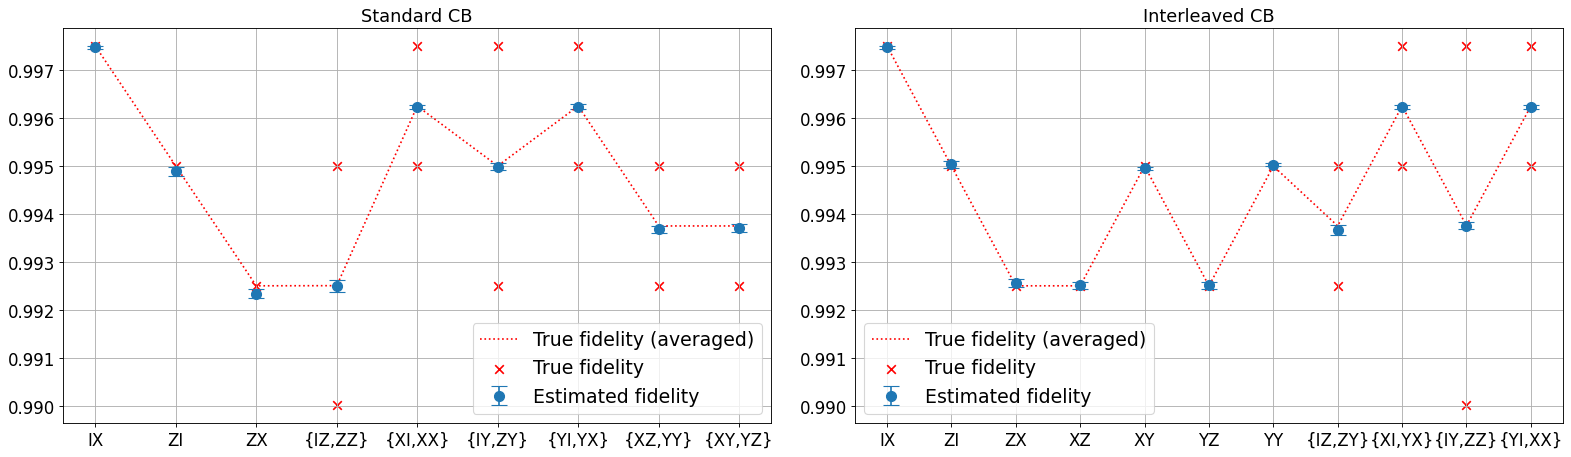

In [362]:

plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=17)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20, 6), dpi=80)

n=2


#plt.scatter(deg_list1[1:],[cb_deg_fidelity[x] for x in deg_list1[1:]])
#ax1.errorbar(deg_list1[1:],[cb_deg_fidelity[x] for x in deg_list1[1:]],[cb_deg_stdev[x] for x in deg_list1[1:]],fmt='o',markersize=6,capsize=4)

ax1.errorbar(reverse_pauli_label(deg_list1[1:]),[cb_deg_fidelity[x] for x in deg_list1[1:]],[cb_deg_stdev[x] for x in deg_list1[1:]],fmt='o',markersize=9,capsize=7)


# ax1.axhline(snr_std,color='g',linestyle='-',linewidth=1)
# ax1.axhspan(snr_std-snr_std_stdev, snr_std+snr_std_stdev, color='g', alpha=0.25,label='_nolegend_')






scatter_x = []
scatter_y = []
for label in deg_list1[1:]:
    if len(label) == len('II'):
        scatter_x.append(label)
        scatter_y.append(f_true[label])
        # ax1.scatter(reverse_pauli_label([label]),f_true[label],c='red',marker='x',label='_nolegend_')
    else:
        scatter_x.append(label)
        scatter_x.append(label)
        scatter_y.append(f_true[label[1:3]])
        scatter_y.append(f_true[label[4:6]])
        # ax1.scatter(reverse_pauli_label([label]),f_true[label[1:3]],c='red',marker='x',label='_nolegend_')
        # ax1.scatter(reverse_pauli_label([label]),f_true[label[4:6]],c='red',marker='x',label='_nolegend_')


ax1.plot(reverse_pauli_label(deg_list1[1:]),[cb_true[x] for x in deg_list1[1:]],ls=':',c='red')

ax1.scatter(reverse_pauli_label(scatter_x),scatter_y,c='red',s=60,marker='x')

# ax1.legend(['estimate','true fidelity'])
ax1.grid(True)
# plt.ylim([0.8,1.005])
ax1.set_title("Standard CB")
# ax1.set_xlabel("Pauli Label")
# ax1.set_ylabel("Fidelity")
ax1.legend(['True fidelity (averaged)','True fidelity','Estimated fidelity'])



n=2
# plt.scatter(deg_list2,[icb_deg_fidelity[x] for x in deg_list2])

ax2.errorbar(reverse_pauli_label(deg_list2[1:]),[icb_deg_fidelity[x] for x in deg_list2[1:]],[icb_deg_stdev[x] for x in deg_list2[1:]],fmt='o',markersize=9,capsize=7)


# ax2.axhline(snr_int,color='g',linestyle='-',linewidth=1)
# ax2.axhspan(snr_int-snr_int_stdev, snr_int+snr_int_stdev, color='g', alpha=0.25, label='_nolegend_')



ax2.plot(reverse_pauli_label(deg_list2[1:]),[icb_true[x] for x in deg_list2[1:]],ls=':',c='red')
# for label in deg_list2[1:]:
#     if len(label) == len('II'):
#         ax2.scatter(reverse_pauli_label([label]),f_true[label],c='red',marker='x',label='_nolegend_')
#     else:
#         ax2.scatter(reverse_pauli_label([label]),f_true[label[1:3]],c='red',marker='x',label='_nolegend_')
#         ax2.scatter(reverse_pauli_label([label]),f_true[label[4:6]],c='red',marker='x',label='_nolegend_')
scatter_x = []
scatter_y = []
for label in deg_list2[1:]:
    if len(label) == len('II'):
        scatter_x.append(label)
        scatter_y.append(f_true[label])
        # ax1.scatter(reverse_pauli_label([label]),f_true[label],c='red',marker='x',label='_nolegend_')
    else:
        scatter_x.append(label)
        scatter_x.append(label)
        scatter_y.append(f_true[label[1:3]])
        scatter_y.append(f_true[label[4:6]])
        # ax1.scatter(reverse_pauli_label([label]),f_true[label[1:3]],c='red',marker='x',label='_nolegend_')
        # ax1.scatter(reverse_pauli_label([label]),f_true[label[4:6]],c='red',marker='x',label='_nolegend_')
ax2.scatter(reverse_pauli_label(scatter_x),scatter_y,c='red',s=60,marker='x')

#plt.errorbar(deg_list2,[icb_deg_fidelity[x] for x in deg_list2],[icb_deg_stdev[x] for x in deg_list2])
# plt.scatter(deg_list1,[f_true[x] for x in deg_list1],,c='red',marker='x')
# plt.scatter(deg_list1,[cb_deg_fidelity[x] for x in deg_list1])
# plt.plot(deg_list2,[icb_true[x] for x in deg_list2],ls=':',c='red')
# for label in deg_list2:
#     if len(label) == len('II'):
#         plt.scatter(label,f_true[label],c='red',marker='x')
#     else:
#         plt.scatter(label,f_true[label[1:3]],c='red',marker='x')
#         plt.scatter(label,f_true[label[4:6]],c='red',marker='x')

# plt.legend([1])
ax2.yaxis.set_tick_params(labelbottom=True)
ax2.grid(True)
# plt.ylim([0.8,1.005])
#plt.title("Pauli Fidelity Estimation (int_CB), C=%d, shots=%d"%(C,shots) +", L=",+str(Lrange))
ax2.set_title("Interleaved CB")
# ax2.set_xlabel("Pauli Label")
# ax2.set_ylabel("Fidelity")
ax2.legend(['True fidelity (averaged)','True fidelity','Estimated fidelity'])

plt.tight_layout()
plt.savefig("f1_sim1.pdf")

C=30, shots=200, L=2-128

Figure 2. Feasible region & Pauli error rate

In [363]:
import sympy as sp
# Create a symbol x
x1 = sp.symbols("x_1") # 1-lambda_IX
x2 = sp.symbols("x_2") # 1-lambda_ZI

full_fidelity = {}
full_stdev = {}

full_fidelity['II'] = 1.0
full_stdev['II'] = 0.0
for label in ['XI','IZ','XZ']:
    full_fidelity[label] = (cb_fidelity_list[label] + icb_fidelity_list[label])/2
    full_stdev[label] = np.sqrt(cb_stdev_list[label]**2 + icb_stdev_list[label]**2)
for label in ['ZX','YX','ZY','YY']:
    full_fidelity[label] = icb_fidelity_list[label]
    full_stdev[label] = icb_stdev_list[label]

full_fidelity['IX'] = 1-x1
full_fidelity['XX'] = cb_deg_fidelity['{IX,XX}']**2 * (1+x1)
full_fidelity['XY'] = icb_deg_fidelity['{IX,XY}']**2 * (1+x1)
full_fidelity['IY'] = icb_deg_fidelity['{IY,XX}']**2/cb_deg_fidelity['{IX,XX}']**2 * (1-x1)

full_fidelity['ZI'] = 1-x2
full_fidelity['ZZ'] = cb_deg_fidelity['{ZI,ZZ}']**2 * (1+x2)
full_fidelity['YZ'] = icb_deg_fidelity['{ZI,YZ}']**2 * (1+x2)
full_fidelity['YI'] = icb_deg_fidelity['{YI,ZZ}']**2/cb_deg_fidelity['{ZI,ZZ}']**2 * (1-x2)

for key,item in full_fidelity.items():
    print(key,1-item)

II 0.0
XI 0.0025310532859248447
IZ 0.005036294214878945
XZ 0.0075413230355623195
ZX 0.007483862986705336
YX 0.005050418926920375
ZY 0.0074835501353526235
YY 0.004968079553094085
IX x_1
XX 0.00753562646152783 - 0.992464373538472*x_1
XY 0.00752354546443357 - 0.992476454535566*x_1
IY 0.999994480366119*x_1 + 5.51963388073506e-6
ZI x_2
ZZ 0.0149462536069679 - 0.985053746393032*x_2
YZ 0.0126273653290435 - 0.987372634670956*x_2
YI 1.00254637638591*x_2 - 0.0025463763859106


In [364]:
######### Pauli error rate calculation
######### Todo: add variance estimation
def int_to_pauli(i,n):
    p = np.base_repr(i,base=4)
    p = '0'*(n-len(p)) + p
    p = p.replace('0','I').replace('1', 'X').replace('2', 'Y').replace('3', 'Z')
    return p

def commute(p,q):
    c = 1
    n = len(p)
    for i in range(n):
        if p[i] != 'I' and q[i] != 'I':
            if p[i] != q[i]:
                c *= -1
    return c

def fidelity_to_error(pauli_fidelity,n):
    N = 4**n
    pauli_error = {}
    for i in range(N):
        p = int_to_pauli(i,n)
        pauli_error[p] = 0
        for j in range(N):
            q = int_to_pauli(j,n)
            pauli_error[p] += pauli_fidelity[q] * commute(p,q) / N
    return pauli_error
    
full_error = fidelity_to_error(full_fidelity,n)
true_error = fidelity_to_error(f_true,n)
# for key,item in full_error.items():
#     print(key,item.subs(x1,0.01).subs(x2,0.013))

learnable_pauli = ['II','XI','IZ','XZ','ZX','YY','YX','ZY']
# for key in learnable_pauli:
#     print(key,full_error[key].subs(x1,0.01).subs(x2,0.013))

# full_error_clear = fidelity_to_error(full_fidelity_clear,n)
# full_error

# true_error = fidelity_to_error(f_true,n)

#### Linear programming -> feasible region

def feasible(x,y,eps=0):
    # d = x.shape[0]
    fm = np.ones(shape=x.shape).astype(bool)
    ### lambda<1
    for label in ['IX','XX','IY','XY','ZI','ZZ','YZ','YI']:
        c = float(full_fidelity[label].subs(x1,0).subs(x2,0))
        a1 = float(full_fidelity[label].subs(x1,1).subs(x2,0)) - c
        a2 = float(full_fidelity[label].subs(x1,0).subs(x2,1)) - c

        # a1*x1 + a2*x2 + c
        fm = fm & (a1*x + a2*y + c <= 1)

    ### prob>0
    for label in ['IX','XX','IY','XY','ZI','ZZ','YZ','YI']:
    #for label in ['II','XI','IZ','XZ','ZX','YY','YX','ZY','ZI','ZZ','IX','XX','YI','YZ','IY','XY']:
        c = float(full_error[label].subs(x1,0).subs(x2,0))
        a1 = float(full_error[label].subs(x1,1).subs(x2,0)) - c
        a2 = float(full_error[label].subs(x1,0).subs(x2,1)) - c
        # a1*x1 + a2*x2 + c
        fm = fm & (a1*x + a2*y + c >= -eps)

    return fm
    

In [365]:
############ Calculate errorbar for Pauli error rates
############ Mar 21, Senrui Chen
unlearnable_pauli = ['IX','XX','IY','XY','ZI','ZZ','YZ','YI']
learnable_pauli = ['II','XI','IZ','XZ','ZX','YY','YX','ZY']

def fidelity_to_error_learnable(pauli_fidelity,pauli_fidelity_std,n):
    N = 4**n
    error = {}
    error_std = {}
    for p in learnable_pauli:
        error[p] = 0.0
        error_std[p] = 0.0
        for q in learnable_pauli:
            error[p] += pauli_fidelity[q] * commute(p,q) / N
            error_std[p] += pauli_fidelity_std[q]**2 / N**2
        # for q in unlearnable_pauli: #change to unlearnable group 1/2, or brute-force coding
        #     pass
        if commute(p,'IX')==commute(p,'XX'):
            # if(p=='XZ'):
            #     print('HIT XZ!')
            assert commute(p,'IY')==commute(p,'XY')
            error[p] += pauli_fidelity['{IX,XX}']*2 * commute(p,'IX') / N
            error[p] += pauli_fidelity['{IY,XY}']*2 * commute(p,'IY') / N
            error_std[p] += (pauli_fidelity_std['{IX,XX}']**2 + pauli_fidelity_std['{IY,XY}']**2) * 4 / N**2
        else:
            assert commute(p,'IX')==commute(p,'XY')
            assert commute(p,'IY')==commute(p,'XX')
            error[p] += pauli_fidelity['{IX,XY}']*2 * commute(p,'IX') / N
            error[p] += pauli_fidelity['{IY,XX}']*2 * commute(p,'IY') / N
            error_std[p] += (pauli_fidelity_std['{IX,XY}']**2 + pauli_fidelity_std['{IY,XX}']**2) * 4 / N**2
            
        if commute(p,'ZI')==commute(p,'ZZ'):
            # if(p=='XZ'):
            #     print('HIT XZ!')
            assert commute(p,'YI')==commute(p,'YZ')
            error[p] += pauli_fidelity['{ZI,ZZ}']*2 * commute(p,'ZI') / N
            error[p] += pauli_fidelity['{YI,YZ}']*2 * commute(p,'YI') / N
            error_std[p] += (pauli_fidelity_std['{ZI,ZZ}']**2 + pauli_fidelity_std['{YI,YZ}']**2) * 4 / N**2
        else:
            assert commute(p,'ZI')==commute(p,'YZ')
            assert commute(p,'YI')==commute(p,'ZZ')
            error[p] += pauli_fidelity['{ZI,YZ}']*2 * commute(p,'ZI') / N
            error[p] += pauli_fidelity['{YI,ZZ}']*2 * commute(p,'YI') / N
            error_std[p] += (pauli_fidelity_std['{ZI,YZ}']**2 + pauli_fidelity_std['{YI,ZZ}']**2) * 4 / N**2


        error_std[p] = np.sqrt(error_std[p])
    return error, error_std

learnable_fidelity = {}
learnable_fstdev = {}

learnable_fidelity['II'] = 1.0
learnable_fstdev['II'] = 0.0
for label in ['XI','IZ','XZ']:
    learnable_fidelity[label] = (cb_fidelity_list[label] + icb_fidelity_list[label])/2
    learnable_fstdev[label] = np.sqrt(cb_stdev_list[label]**2 + icb_stdev_list[label]**2)
for label in ['ZX','YX','ZY','YY']:
    learnable_fidelity[label] = icb_fidelity_list[label]
    learnable_fstdev[label] = icb_stdev_list[label]
for label in ['{IX,XX}','{ZI,ZZ}','{IY,XY}','{YI,YZ}']:
    learnable_fidelity[label] = cb_deg_fidelity[label]
    learnable_fstdev[label] = cb_deg_stdev[label]
for label in ['{IX,XY}','{ZI,YZ}','{IY,XX}','{YI,ZZ}']:
    learnable_fidelity[label] = icb_deg_fidelity[label]
    learnable_fstdev[label] = icb_deg_stdev[label]

learnable_error, learnable_error_std = fidelity_to_error_learnable(learnable_fidelity,learnable_fstdev,2)


In [366]:
### plot feasible region
import numpy as np
import matplotlib.pyplot as plt



# plot the feasible region
d = np.linspace(0.002,0.0105,1000)
_x,_y = np.meshgrid(d,d)
print(_x.shape)
eps = 0
#plt.imshow( (feasible(x,y,eps)), extent=(x.min(),x.max(),y.min(),y.max()),origin="lower", cmap="Greys", alpha = 0.3);
feasible_grid = feasible(_x,_y,max(learnable_error_std.values()))
# feasible_grid = feasible(_x,_y,0)


for k in range(len(d)):
    flag = False
    for j in range(len(d)):
        if feasible_grid[k][j] == True:
            flag = True
            break
    if flag:
        break
print("y_low",_y[k][0])
y_l = _y[k][0]

for k in range(len(d)-1,-1,-1):
    flag = False
    for j in range(len(d)):
        if feasible_grid[k][j] == True:
            flag = True
            break
    if flag:
        break
print("y_high",_y[k][0])
y_h = _y[k][0]

for k in range(len(d)):
    flag = False
    for j in range(len(d)):
        if feasible_grid[j][k] == True:
            flag = True
            break
    if flag:
        break
print("x_low",_x[0][k])
x_l = _x[0][k]

for k in range(len(d)-1,-1,-1):
    flag = False
    for j in range(len(d)):
        if feasible_grid[j][k] == True:
            flag = True
            break
    if flag:
        break
print("x_high",_x[0][k])
x_h = _x[0][k]



(1000, 1000)
y_low 0.004977977977977978
y_high 0.010168168168168169
x_low 0.0024424424424424425
x_high 0.0026721721721721724


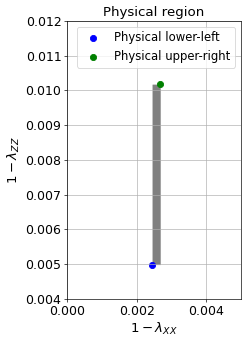

In [367]:
plt.figure(figsize=(6, 6), dpi=60)
plt.imshow( feasible_grid.astype(int) , 
                extent=(_x.min(),_x.max(),_y.min(),_y.max()),origin="lower", cmap="Greys", alpha = 0.5)

# # Make plot
# plt.plot(x, 2*np.ones_like(y1))
# plt.plot(x, y2, label=r'$2y\leq25-x$')
# plt.plot(x, y3, label=r'$4y\geq 2x - 8$')
# plt.plot(x, y4, label=r'$y\leq 2x-5$')
# plt.xlim(0,16)
# plt.ylim(0,11)

plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title



plt.title("Physical region")
plt.xlabel(r'$1-\lambda_{XX}$')
plt.ylabel(r'$1-\lambda_{ZZ}$')

plt.scatter(x_l,y_l,c='b',s=55)

plt.scatter(x_h,y_h,c='g',s=55)

plt.legend(['Physical lower-left','Physical upper-right'])

xlen = x_h - x_l
ylen = y_h - y_l
plt.xlim([0,0.005])
#plt.xlim([x_l-0.2*xlen,x_h+0.2*xlen])
# plt.ylim([y_l-0.2*ylen,y_h+0.2*ylen])
plt.ylim([0.004,0.012])
plt.grid('on')

plt.tight_layout()
plt.savefig("f2_sim1.pdf")

In [368]:
# # pauli_request_list = ['XI','IZ','XZ','ZX','YY','YX','ZY','ZI','ZZ','IX','XX','YI','YZ','IY','XY']
# #pauli_request_list = ['XI','IZ','XZ','ZX','YY','YX','ZY','ZI','YI','ZZ','YZ','IX','IY','XX','XY']

# pauli_request_list = learnable_pauli[1:] + unlearnable_pauli

# f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20, 6), dpi=80)



# # ax1.errorbar(reverse_pauli_label(learnable_pauli[1:]),[learnable_error[x] for x in learnable_pauli[1:]],[learnable_error_std[x] for x in learnable_pauli[1:]],fmt='o',capsize=4)

# unlearnable_high = []
# unlearnable_low = []
# for x in unlearnable_pauli:
#     if full_error[x].subs(x1,x_l).subs(x2,y_l) > full_error[x].subs(x1,x_h).subs(x2,y_h):
#         unlearnable_high.append(float(full_error[x].subs(x1,x_l).subs(x2,y_l)))
#         unlearnable_low.append(float(full_error[x].subs(x1,x_h).subs(x2,y_h)))
#     else:
#         unlearnable_high.append(float(full_error[x].subs(x1,x_h).subs(x2,y_h)))
#         unlearnable_low.append(float(full_error[x].subs(x1,x_l).subs(x2,y_l)))

# ax1.plot(reverse_pauli_label(pauli_request_list),list(full_error[x].subs(x1,x_l).subs(x2,y_l) for x in pauli_request_list),marker='o',ls='none', c ='blue')
# #plt.plot(pauli_request_list,list(full_error[x].subs(x1,x_h).subs(x2,y_l) for x in pauli_request_list),marker='o')
# #plt.plot(pauli_request_list,list(full_error[x].subs(x1,x_l).subs(x2,y_h) for x in pauli_request_list),marker='o')
# #ax1.plot(reverse_pauli_label(pauli_request_list),list(full_error[x].subs(x1,x_h).subs(x2,y_h) for x in pauli_request_list),marker='o',ls='none', c = 'green')
# #ax1.vlines(reverse_pauli_label(unlearnable_pauli),unlearnable_low,unlearnable_high,label='_nolegend_',colors='purple')
# ax1.axvline(6.5,ls='-.',linewidth=1.0,c='red',label='_nolegend_')


# # plt.errorbar(pauli_request_list,list(full_error[x] for x in pauli_request_list),yerr = None)
# # plt.scatter(pauli_request_list,list(true_error[x] for x in pauli_request_list),c='red',marker='x')
# # plt.legend([1])
# ax1.grid(True)
# ax1.xaxis.set_tick_params(labelbottom=True)
# # plt.title("Pauli Error Rate Estimation (Intercept-CB), C=%d, shots=%d"%(C_intc,shots_intc) +", L=",+str(Lrange))
# ax1.set_title("Physical region (error rates), C=%d, shots=%d, L=%s"%(C_intc,shots_intc,str(Lrange)))
# ax1.set_xlabel("Pauli Label")
# ax1.set_ylabel("Error rate")


# ax1.plot(reverse_pauli_label(pauli_request_list), list(true_error[x] for x in pauli_request_list),marker='x',markersize=5,ls='none',c='r')

# # plt.legend(['physical_lower_left','physical_lower_right','physical_upper_left','physical_upper_right'])
# ax1.legend(['Physical lower-left','True error rate'])

# ax1.vlines(reverse_pauli_label(learnable_pauli[1:])+reverse_pauli_label(unlearnable_pauli),\
#      [learnable_error[x]-learnable_error_std[x] for x in learnable_pauli[1:]] + unlearnable_low, \
#          [learnable_error[x]+learnable_error_std[x] for x in learnable_pauli[1:]] + unlearnable_high, alpha=0.3,linewidth=12)



# # print(unlearnable_pauli,unlearnable_low,unlearnable_high)

# ####fig rhs
# #ax1.plot(reverse_pauli_label(pauli_request_list),list(full_error[x].subs(x1,x_l).subs(x2,y_l) for x in pauli_request_list),marker='o',ls='none', c ='blue')
# #plt.plot(pauli_request_list,list(full_error[x].subs(x1,x_h).subs(x2,y_l) for x in pauli_request_list),marker='o')
# #plt.plot(pauli_request_list,list(full_error[x].subs(x1,x_l).subs(x2,y_h) for x in pauli_request_list),marker='o')

# ax2.plot(reverse_pauli_label(pauli_request_list),list(full_error[x].subs(x1,x_h).subs(x2,y_h) for x in pauli_request_list),marker='o',ls='none', c = 'green')
# ax2.plot(reverse_pauli_label(pauli_request_list), list(true_error[x] for x in pauli_request_list),marker='x',markersize=5,ls='none',c='r')

# #ax1.vlines(reverse_pauli_label(unlearnable_pauli),unlearnable_low,unlearnable_high,label='_nolegend_',colors='purple')
# ax2.axvline(6.5,ls='-.',linewidth=1.0,c='red',label='_nolegend_')


# # plt.errorbar(pauli_request_list,list(full_error[x] for x in pauli_request_list),yerr = None)
# # plt.scatter(pauli_request_list,list(true_error[x] for x in pauli_request_list),c='red',marker='x')
# # plt.legend([1])
# ax2.grid(True)
# ax2.yaxis.set_tick_params(labelbottom=True)
# # plt.title("Pauli Error Rate Estimation (Intercept-CB), C=%d, shots=%d"%(C_intc,shots_intc) +", L=",+str(Lrange))
# ax2.set_title("Physical region (error rates), C=%d, shots=%d, L=%s"%(C_intc,shots_intc,str(Lrange)))
# ax2.set_xlabel("Pauli Label")
# ax2.set_ylabel("Error rate")

# # plt.legend(['physical_lower_left','physical_lower_right','physical_upper_left','physical_upper_right'])
# ax2.legend(['Physical upper-right', 'True error rate'])

# ax2.vlines(reverse_pauli_label(learnable_pauli[1:])+reverse_pauli_label(unlearnable_pauli),\
#      [learnable_error[x]-learnable_error_std[x] for x in learnable_pauli[1:]] + unlearnable_low, \
#          [learnable_error[x]+learnable_error_std[x] for x in learnable_pauli[1:]] + unlearnable_high, alpha=0.3, linewidth=12)


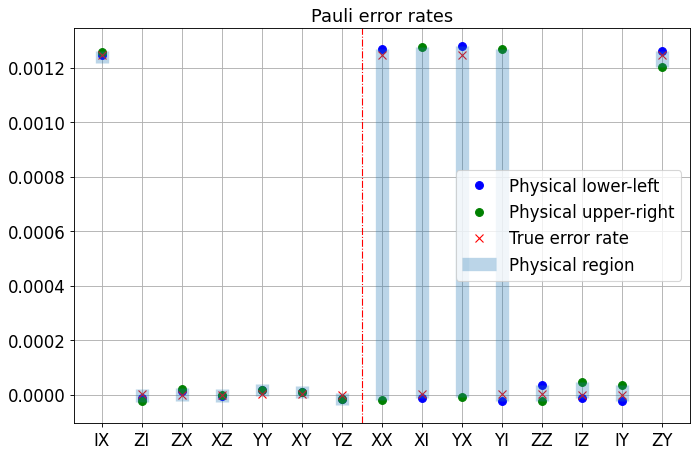

In [369]:
# pauli_request_list = ['XI','IZ','XZ','ZX','YY','YX','ZY','ZI','ZZ','IX','XX','YI','YZ','IY','XY']
#pauli_request_list = ['XI','IZ','XZ','ZX','YY','YX','ZY','ZI','YI','ZZ','YZ','IX','IY','XX','XY']



plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

pauli_request_list = learnable_pauli[1:] + unlearnable_pauli

# f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20, 6), dpi=80)

plt.figure(figsize=(9, 6), dpi=80)


# ax1.errorbar(reverse_pauli_label(learnable_pauli[1:]),[learnable_error[x] for x in learnable_pauli[1:]],[learnable_error_std[x] for x in learnable_pauli[1:]],fmt='o',capsize=4)

unlearnable_high = []
unlearnable_low = []
for x in unlearnable_pauli:
    if full_error[x].subs(x1,x_l).subs(x2,y_l) > full_error[x].subs(x1,x_h).subs(x2,y_h):
        unlearnable_high.append(float(full_error[x].subs(x1,x_l).subs(x2,y_l)))
        unlearnable_low.append(float(full_error[x].subs(x1,x_h).subs(x2,y_h)))
    else:
        unlearnable_high.append(float(full_error[x].subs(x1,x_h).subs(x2,y_h)))
        unlearnable_low.append(float(full_error[x].subs(x1,x_l).subs(x2,y_l)))

plt.plot(reverse_pauli_label(pauli_request_list),list(full_error[x].subs(x1,x_l).subs(x2,y_l) for x in pauli_request_list),marker='o',ls='none', c ='blue',markersize=7)
plt.plot(reverse_pauli_label(pauli_request_list),list(full_error[x].subs(x1,x_h).subs(x2,y_h) for x in pauli_request_list),marker='o',ls='none', c = 'green',markersize=7)
#plt.plot(pauli_request_list,list(full_error[x].subs(x1,x_h).subs(x2,y_l) for x in pauli_request_list),marker='o')
#plt.plot(pauli_request_list,list(full_error[x].subs(x1,x_l).subs(x2,y_h) for x in pauli_request_list),marker='o')
#ax1.plot(reverse_pauli_label(pauli_request_list),list(full_error[x].subs(x1,x_h).subs(x2,y_h) for x in pauli_request_list),marker='o',ls='none', c = 'green')
#ax1.vlines(reverse_pauli_label(unlearnable_pauli),unlearnable_low,unlearnable_high,label='_nolegend_',colors='purple')
plt.axvline(6.5,ls='-.',linewidth=1.0,c='red',label='_nolegend_')


# plt.errorbar(pauli_request_list,list(full_error[x] for x in pauli_request_list),yerr = None)
# plt.scatter(pauli_request_list,list(true_error[x] for x in pauli_request_list),c='red',marker='x')
# plt.legend([1])
plt.grid(True)
# plt.title("Pauli Error Rate Estimation (Intercept-CB), C=%d, shots=%d"%(C_intc,shots_intc) +", L=",+str(Lrange))
#plt.title("Physical region (error rates), C=%d, shots=%d, L=%s"%(C_intc,shots_intc,str(Lrange)))
plt.title("Pauli error rates")
# plt.xlabel("Pauli Label")
# plt.ylabel("Error rate")


plt.plot(reverse_pauli_label(pauli_request_list), list(true_error[x] for x in pauli_request_list),marker='x',markersize=7,ls='none',c='r')

# plt.legend(['physical_lower_left','physical_lower_right','physical_upper_left','physical_upper_right'])


plt.vlines(reverse_pauli_label(learnable_pauli[1:])+reverse_pauli_label(unlearnable_pauli),\
     [learnable_error[x]-learnable_error_std[x] for x in learnable_pauli[1:]] + unlearnable_low, \
         [learnable_error[x]+learnable_error_std[x] for x in learnable_pauli[1:]] + unlearnable_high, alpha=0.3,linewidth=12)
plt.legend(['Physical lower-left','Physical upper-right','True error rate','Physical region'])



plt.tight_layout()
plt.savefig("f2_error_sim1.pdf")


In [370]:
# pauli_request_list = learnable_pauli[1:] + unlearnable_pauli

# f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20, 6), dpi=80)



# unlearnable_high_f = []
# unlearnable_low_f = []
# for x in unlearnable_pauli:
#     if full_fidelity[x].subs(x1,x_l).subs(x2,y_l) > full_fidelity[x].subs(x1,x_h).subs(x2,y_h):
#         unlearnable_high_f.append(float(full_fidelity[x].subs(x1,x_l).subs(x2,y_l)))
#         unlearnable_low_f.append(float(full_fidelity[x].subs(x1,x_h).subs(x2,y_h)))
#     else:
#         unlearnable_high_f.append(float(full_fidelity[x].subs(x1,x_h).subs(x2,y_h)))
#         unlearnable_low_f.append(float(full_fidelity[x].subs(x1,x_l).subs(x2,y_l)))



# ####subfig 1
# # ax2.errorbar(reverse_pauli_label(learnable_pauli[1:]),[learnable_fidelity[x] for x in learnable_pauli[1:]],[learnable_fstdev[x] for x in learnable_pauli[1:]],fmt='o',capsize=4)
# #ax1.plot(reverse_pauli_label(unlearnable_pauli),list((full_fidelity[x]).subs(x1,x_l).subs(x2,y_l) for x in unlearnable_pauli),marker='o',ls='none', c ='blue')
# #plt.plot(pauli_request_list,list(full_error[x].subs(x1,x_h).subs(x2,y_l) for x in pauli_request_list),marker='o')
# #plt.plot(pauli_request_list,list(full_error[x].subs(x1,x_l).subs(x2,y_h) for x in pauli_request_list),marker='o')
# ax1.plot(reverse_pauli_label(pauli_request_list),[learnable_fidelity[x] for x in learnable_pauli[1:]] + list((full_fidelity[x]).subs(x1,x_l).subs(x2,y_l) for x in unlearnable_pauli),marker='o',ls='none', c = 'blue')
# #ax2.vlines(reverse_pauli_label(unlearnable_pauli),unlearnable_low_f,unlearnable_high_f,label='_nolegend_',colors='purple')
# ax1.axvline(6.5,ls='-.',linewidth=1.0,c='red',label='_nolegend_')

# ax1.grid(True)
# ax1.set_title("Physical region (fidelity), C=%d, shots=%d, L=%s"%(C_intc,shots_intc,str(Lrange)))
# ax1.set_xlabel("Pauli Label")
# ax1.set_ylabel("Fidelity")


# ax1.plot(reverse_pauli_label(pauli_request_list), list(f_true[x] for x in pauli_request_list),marker='x',markersize=5,ls='none',c='r')

# # ax1.legend(['physical lower-left','physical upper-right','learnable'])
# ax1.vlines(reverse_pauli_label(learnable_pauli[1:])+reverse_pauli_label(unlearnable_pauli),\
#      [learnable_fidelity[x]-learnable_fstdev[x] for x in learnable_pauli[1:]] + unlearnable_low_f, \
#          [learnable_fidelity[x]+learnable_fstdev[x] for x in learnable_pauli[1:]] + unlearnable_high_f, alpha=0.3, linewidth=12.0)

# ax1.legend(['Physical lower-left', 'True fidelity','Physical region'])

# ####subfig 2
# # ax2.errorbar(reverse_pauli_label(learnable_pauli[1:]),[learnable_fidelity[x] for x in learnable_pauli[1:]],[learnable_fstdev[x] for x in learnable_pauli[1:]],fmt='o',capsize=4)
# #ax2.plot(reverse_pauli_label(unlearnable_pauli),list((full_fidelity[x]).subs(x1,x_l).subs(x2,y_l) for x in unlearnable_pauli),marker='o',ls='none', c ='blue')
# #plt.plot(pauli_request_list,list(full_error[x].subs(x1,x_h).subs(x2,y_l) for x in pauli_request_list),marker='o')
# #plt.plot(pauli_request_list,list(full_error[x].subs(x1,x_l).subs(x2,y_h) for x in pauli_request_list),marker='o')
# ax2.plot(reverse_pauli_label(pauli_request_list),[learnable_fidelity[x] for x in learnable_pauli[1:]] + list((full_fidelity[x]).subs(x1,x_h).subs(x2,y_h) for x in unlearnable_pauli),marker='o',ls='none', c = 'green')
# #ax2.vlines(reverse_pauli_label(unlearnable_pauli),unlearnable_low_f,unlearnable_high_f,label='_nolegend_',colors='purple')
# ax2.axvline(6.5,ls='-.',linewidth=1.0,c='red',label='_nolegend_')

# ax2.grid(True)
# ax2.set_title("Physical region (fidelity), C=%d, shots=%d, L=%s"%(C_intc,shots_intc,str(Lrange)))
# ax2.set_xlabel("Pauli Label")
# ax2.set_ylabel("Fidelity")
# ax2.yaxis.set_tick_params(labelbottom=True)

# ax2.plot(reverse_pauli_label(pauli_request_list), list(f_true[x] for x in pauli_request_list),marker='x',markersize=5,ls='none',c='r')


# ax2.vlines(reverse_pauli_label(learnable_pauli[1:])+reverse_pauli_label(unlearnable_pauli),\
#      [learnable_fidelity[x]-learnable_fstdev[x] for x in learnable_pauli[1:]] + unlearnable_low_f, \
#          [learnable_fidelity[x]+learnable_fstdev[x] for x in learnable_pauli[1:]] + unlearnable_high_f, alpha=0.3, linewidth=12.0)

# ax2.legend(['Physical upper-right', 'True fidelity','Physical region'])

Fig 3: Intercept CB

In [371]:
# ####### use intercept information (Todo: Stdev analysis)
intc_fidelity = {}
intc_stdev = {}

intc_fidelity['II'] = 1.0
intc_stdev['II'] = 0.0
for label in ['XI','IZ','XZ']:
    intc_fidelity[label] = (cb_fidelity_list[label] + icb_fidelity_list[label])/2
    intc_stdev[label] = np.sqrt(cb_stdev_list[label]**2 + icb_stdev_list[label]**2)
for label in ['ZX','YX','ZY','YY']:
    intc_fidelity[label] = icb_fidelity_list[label]
    intc_stdev[label] = icb_stdev_list[label]

intc_fidelity['ZI'] = result['intc_cb']['dec_fidelity']['ZI']
intc_fidelity['ZZ'] = result['intc_cb']['dec_fidelity']['ZZ']
intc_fidelity['XX'] = result['intc_cb']['dec_fidelity']['XX']
intc_fidelity['IX'] = result['intc_cb']['dec_fidelity']['IX']
intc_fidelity['YZ'] = icb_deg_fidelity['{ZI,YZ}']**2/intc_fidelity['ZI']
intc_fidelity['YI'] = icb_deg_fidelity['{YI,ZZ}']**2/intc_fidelity['ZZ']
intc_fidelity['IY'] = icb_deg_fidelity['{IY,XX}']**2/intc_fidelity['XX']
intc_fidelity['XY'] = icb_deg_fidelity['{IX,XY}']**2/intc_fidelity['IX']

intc_stdev['ZI'] = result['intc_cb']['dec_stdev']['ZI']
intc_stdev['ZZ'] = result['intc_cb']['dec_stdev']['ZZ']
intc_stdev['XX'] = result['intc_cb']['dec_stdev']['XX']
intc_stdev['IX'] = result['intc_cb']['dec_stdev']['IX']
intc_stdev['YZ'] = np.sqrt(4 * icb_deg_fidelity['{ZI,YZ}']**2/intc_fidelity['ZI']**2 * icb_deg_stdev['{ZI,YZ}']**2 + icb_deg_fidelity['{ZI,YZ}']**4/intc_fidelity['ZI']**4 * intc_stdev['ZI']**2)
intc_stdev['YI'] = np.sqrt(4 * icb_deg_fidelity['{YI,ZZ}']**2/intc_fidelity['ZZ']**2 * icb_deg_stdev['{YI,ZZ}']**2 + icb_deg_fidelity['{YI,ZZ}']**4/intc_fidelity['ZZ']**4 * intc_stdev['ZZ']**2)
intc_stdev['IY'] = np.sqrt(4 * icb_deg_fidelity['{IY,XX}']**2/intc_fidelity['XX']**2 * icb_deg_stdev['{IY,XX}']**2 + icb_deg_fidelity['{IY,XX}']**4/intc_fidelity['XX']**4 * intc_stdev['XX']**2)
intc_stdev['XY'] = np.sqrt(4 * icb_deg_fidelity['{IX,XY}']**2/intc_fidelity['IX']**2 * icb_deg_stdev['{IX,XY}']**2 + icb_deg_fidelity['{IX,XY}']**4/intc_fidelity['IX']**4 * intc_stdev['IX']**2)

snr_intc = 0
for label,f in intc_fidelity.items():
    if len(label)==len('II'):
        snr_intc += f
    else:
        snr_intc +=2*f
snr_intc /= 16

snr_intc_stdev = 0
for label,std in intc_stdev.items():
    if len(label)==len('II'):
        snr_intc_stdev += std**2
    else:
        snr_intc_stdev +=4*std**2
snr_intc_stdev = np.sqrt(snr_intc_stdev)/16


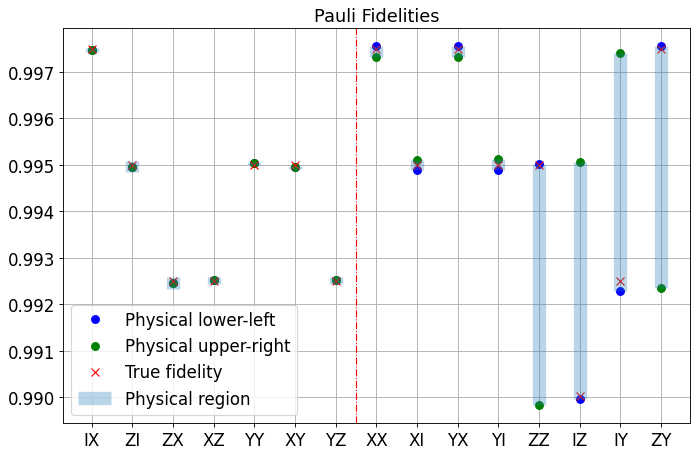

In [372]:
pauli_request_list = learnable_pauli[1:] + unlearnable_pauli

# f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20, 6), dpi=80)

f = plt.figure(figsize=(9,6),dpi=80)

unlearnable_high_f = []
unlearnable_low_f = []
for x in unlearnable_pauli:
    if full_fidelity[x].subs(x1,x_l).subs(x2,y_l) > full_fidelity[x].subs(x1,x_h).subs(x2,y_h):
        unlearnable_high_f.append(float(full_fidelity[x].subs(x1,x_l).subs(x2,y_l)))
        unlearnable_low_f.append(float(full_fidelity[x].subs(x1,x_h).subs(x2,y_h)))
    else:
        unlearnable_high_f.append(float(full_fidelity[x].subs(x1,x_h).subs(x2,y_h)))
        unlearnable_low_f.append(float(full_fidelity[x].subs(x1,x_l).subs(x2,y_l)))



####subfig 1
# ax2.errorbar(reverse_pauli_label(learnable_pauli[1:]),[learnable_fidelity[x] for x in learnable_pauli[1:]],[learnable_fstdev[x] for x in learnable_pauli[1:]],fmt='o',capsize=4)
#ax1.plot(reverse_pauli_label(unlearnable_pauli),list((full_fidelity[x]).subs(x1,x_l).subs(x2,y_l) for x in unlearnable_pauli),marker='o',ls='none', c ='blue')
#plt.plot(pauli_request_list,list(full_error[x].subs(x1,x_h).subs(x2,y_l) for x in pauli_request_list),marker='o')
#plt.plot(pauli_request_list,list(full_error[x].subs(x1,x_l).subs(x2,y_h) for x in pauli_request_list),marker='o')
plt.plot(reverse_pauli_label(pauli_request_list),[learnable_fidelity[x] for x in learnable_pauli[1:]] + list((full_fidelity[x]).subs(x1,x_l).subs(x2,y_l) for x in unlearnable_pauli),marker='o',ls='none', c = 'blue',markersize=7)
plt.plot(reverse_pauli_label(pauli_request_list),[learnable_fidelity[x] for x in learnable_pauli[1:]] + list((full_fidelity[x]).subs(x1,x_h).subs(x2,y_h) for x in unlearnable_pauli),marker='o',ls='none', c = 'green',markersize=7)

#ax2.vlines(reverse_pauli_label(unlearnable_pauli),unlearnable_low_f,unlearnable_high_f,label='_nolegend_',colors='purple')
plt.axvline(6.5,ls='-.',linewidth=1.0,c='red',label='_nolegend_')

plt.grid(True)
# plt.title("Physical region (fidelity), C=%d, shots=%d, L=%s"%(C_intc,shots_intc,str(Lrange)))
# plt.xlabel("Pauli Label")
# plt.ylabel("Fidelity")
plt.title("Pauli Fidelities")


plt.plot(reverse_pauli_label(pauli_request_list), list(f_true[x] for x in pauli_request_list),marker='x',markersize=7,ls='none',c='r')

# ax1.legend(['physical lower-left','physical upper-right','learnable'])
plt.vlines(reverse_pauli_label(learnable_pauli[1:])+reverse_pauli_label(unlearnable_pauli),\
     [learnable_fidelity[x]-learnable_fstdev[x] for x in learnable_pauli[1:]] + unlearnable_low_f, \
         [learnable_fidelity[x]+learnable_fstdev[x] for x in learnable_pauli[1:]] + unlearnable_high_f, alpha=0.3, linewidth=12.0)

plt.legend(['Physical lower-left', 'Physical upper-right', 'True fidelity','Physical region'])

plt.tight_layout()
plt.savefig("f2_fid_sim1.pdf")

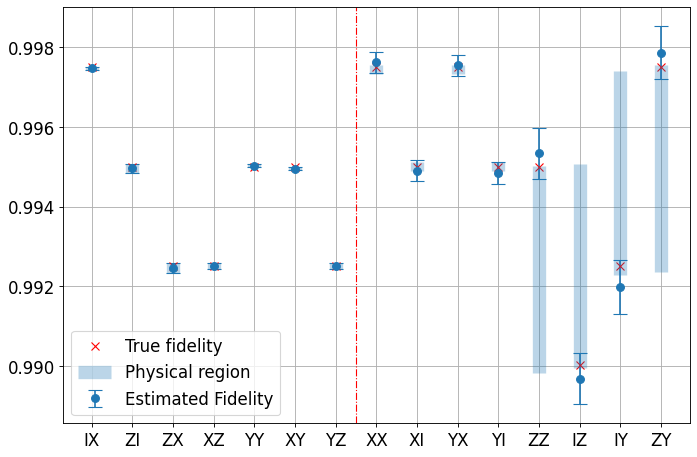

In [373]:
plt.figure(figsize=(9, 6), dpi=80)
n=2


#plt.scatter(pauli_request_list,list(intc_fidelity[x] for x in pauli_request_list))
plt.errorbar(reverse_pauli_label(pauli_request_list),list(intc_fidelity[x] for x in pauli_request_list),yerr = list(intc_stdev[x] for x in pauli_request_list),fmt='o',markersize=7,capsize=6)

plt.plot(reverse_pauli_label(pauli_request_list), list(f_true[x] for x in pauli_request_list),marker='x',markersize=7,ls='none',c='r')

plt.axvline(6.5,ls='-.',linewidth=1.0,c='red',label='_nolegend_')
#plt.axhline(1.0,ls='--',linewidth=1.0,c='black',label='_nolegend_')

# plt.axhline(snr_intc,color='g',linestyle='-',linewidth=1)
# plt.axhspan(snr_intc-snr_intc_stdev, snr_intc+snr_intc_stdev, color='g', alpha=0.25, label='_nolegend_')
# plt.scatter(pauli_request_list,list(f_true[x] for x in pauli_request_list),c='red',marker='x')
#plt.plot(pauli_request_list,list(f_true[x] for x in pauli_request_list),ls=':',c='red',marker='x')
plt.vlines(reverse_pauli_label(learnable_pauli[1:])+reverse_pauli_label(unlearnable_pauli),\
     [learnable_fidelity[x]-learnable_fstdev[x] for x in learnable_pauli[1:]] + unlearnable_low_f, \
         [learnable_fidelity[x]+learnable_fstdev[x] for x in learnable_pauli[1:]] + unlearnable_high_f, alpha=0.3, linewidth=12.0)

plt.legend(['True fidelity','Physical region','Estimated Fidelity',])
plt.grid(True)
#plt.title("Pauli Fidelity Estimation (Intercept-CB), C=%d, shots=%d, L=%s"%(C_intc,shots_intc,str(Lrange)))
# plt.xlabel("Pauli Label")
# plt.ylabel("fidelity")

plt.tight_layout()
plt.savefig("f3_fid_sim1.pdf")

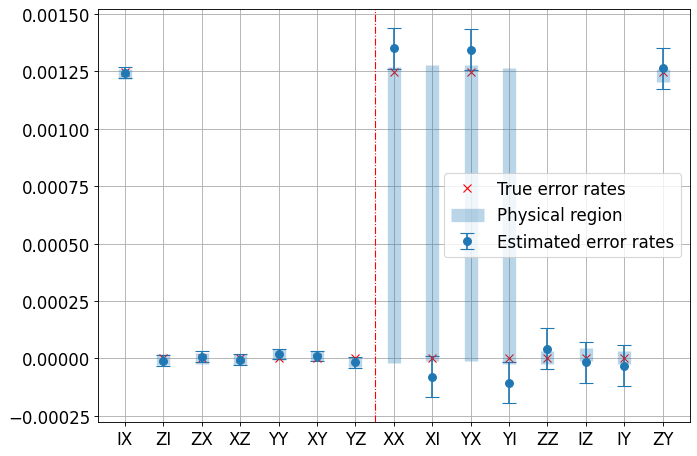

In [374]:
intc_error = fidelity_to_error(intc_fidelity,n)
#true_error #already defined

plt.figure(figsize=(9, 6), dpi=80)
#plt.scatter(pauli_request_list,list(intc_error[x] for x in pauli_request_list))

plt.errorbar(reverse_pauli_label(pauli_request_list),list(intc_error[x] for x in pauli_request_list), [learnable_error_std[x] for x in learnable_pauli[1:]] + [snr_intc_stdev] * len(unlearnable_pauli), fmt='o',markersize=7 ,capsize=6)

plt.plot(reverse_pauli_label(pauli_request_list), list(true_error[x] for x in pauli_request_list),marker='x',markersize=7,ls='none',c='r')

# plt.scatter(pauli_request_list,list(true_error[x] for x in pauli_request_list),c='red',marker='x')


plt.axvline(6.5,ls='-.',linewidth=1.0,c='red',label='_nolegend_')
# plt.axhline(0.0,ls='--',linewidth=1.0,c='black',label='_nolegend_')

plt.vlines(reverse_pauli_label(learnable_pauli[1:])+reverse_pauli_label(unlearnable_pauli),\
     [learnable_error[x]-learnable_error_std[x] for x in learnable_pauli[1:]] + unlearnable_low, \
         [learnable_error[x]+learnable_error_std[x] for x in learnable_pauli[1:]] + unlearnable_high, alpha=0.3, linewidth=12.0)

plt.legend(['True error rates', 'Physical region','Estimated error rates'])
plt.grid(True)
# plt.ylim([0.8,1.005])
# plt.title("Pauli Error Rate Estimation (Intercept-CB), C=%d, shots=%d"%(C_intc,shots_intc) +", L=",+str(Lrange))
#plt.title("Pauli Error Rate Estimation (Intercept-CB), C=%d, shots=%d, L=%s"%(C_intc,shots_intc,str(Lrange)))
# plt.xlabel("Pauli Label")
# plt.ylabel("Error rate")

plt.tight_layout()
plt.savefig("f3_error_sim1.pdf")